# Group 14 - Project FP01
## Time series anomaly detection - LSTM-AD

This project aims at investigating the current state-of-the-arts TAD scenario.

In [1]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install keras_tuner
# !pip install -U kaleido

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataset import get_df_action, get_features_ts, get_train_test_data, label_collision_data, predict_anomaly_score
from plots import seaborn_cm, create_and_plot_cm, plot_uncertainty, plot_signals, plot_anomalies, plot_anomalies_over_time, plot_roc_curve, plot_all_anomalies_over_time
from metrics import Confidence, anomaly_detection_metric, compute_metrics, compute_various_thresholds

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [3]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal'#'/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'#'/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [4]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')
collision_rec5 = pd.read_excel(xls, 'rec5')

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

collisions_adjusted = collisions.Timestamp - pd.to_timedelta([2] * len(collisions.Timestamp), 'h')
collisions_adjusted_rec_1 = collision_rec1.Timestamp - pd.to_timedelta([2] * len(collision_rec1.Timestamp), 'h')
collisions_adjusted_rec_5 = collision_rec5.Timestamp - pd.to_timedelta([2] * len(collision_rec5.Timestamp), 'h')

# transform in like collision
collisions['Timestamp'] = collisions_adjusted
collision_rec1['Timestamp'] = collisions_adjusted_rec_1
collision_rec5['Timestamp'] = collisions_adjusted_rec_5

# COLLISION DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_1, df_collision_1, df_meta_collision_1, action2int_collision_1 = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_5, df_collision_5, df_meta_collision_5, action2int_collision_5 = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



### Features Exctraction

In [5]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
df_features_collision_1 = get_features_ts("statistical", df_action_collision_1, df_meta_collision_1, frequency, action2int_collision_1)
df_features_collision_5 = get_features_ts("statistical", df_action_collision_5, df_meta_collision_5, frequency, action2int_collision_5)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
Computing features.


Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 157.54752826690674 seconds ---


In [6]:
X_train, y_train, X_test, y_test = get_train_test_data(df_features, df_features_collision, full_normal=True)
X_train1, y_train1, X_test1, y_test1 = get_train_test_data(df_features, df_features_collision_1, full_normal=True)
X_train5, y_train5, X_test5, y_test5 = get_train_test_data(df_features, df_features_collision_5, full_normal=True)

In [7]:
df_with_labels = label_collision_data(df_features_collision, collisions_init)
df_with_labels_1 = label_collision_data(df_features_collision_1, collisions_adjusted_rec_1)
df_with_labels_5 = label_collision_data(df_features_collision_5, collisions_adjusted_rec_5)

In [8]:
y_collision = df_with_labels['is_collision']
y_collision_1 = df_with_labels_1['is_collision']
y_collision_5 = df_with_labels_5['is_collision']


## LSTM-AD

In [9]:
from algorithms.lstm_ad import LSTMAD

def prepare_data_for_lstm(data, len_in):
    """
    Prepare data for LSTM-AD by concatenating every len_in rows.
    """
    n_features = data.shape[1]
    n_samples = data.shape[0] // len_in
    prepared_data = data.iloc[:n_samples * len_in].values.reshape(n_samples, -1)
    return pd.DataFrame(prepared_data, index=data.index[len_in-1:len_in*n_samples:len_in])

# CURRENTLY FUCKS UP FOR VALUES OF LEN_IN AND LEN_OUT DIFFERENT FROM 1
len_in = 1
X_train_lstm = prepare_data_for_lstm(X_train, len_in)
print(X_train_lstm.shape)

classifier = LSTMAD(
    len_in=len_in,         # Input sequence length
    len_out=1,             # Output sequence length (prediction horizon)
    num_epochs=100,         # Number of training epochs
    lr=1e-3,               # Learning rate
    batch_size=1,          # Batch size (usually 1 for time series)
    seed=42,               # Random seed for reproducibility
    gpu=None,              # Set to None for CPU, or specify GPU index if available
    details=True           # Set to True to get detailed predictions
)

# Train the LSTM on normal data
classifier.fit(X_train_lstm)
print("LSTM-AD training completed.")


(973, 96)


100%|██████████| 100/100 [00:34<00:00,  2.90it/s]

LSTM-AD training completed.


### Anomaly Detection

In [10]:
anomaly_scores = predict_anomaly_score(X_test, classifier)
anomaly_scores1 = predict_anomaly_score(X_test1, classifier)
anomaly_scores5 = predict_anomaly_score(X_test5, classifier)

Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.


In [11]:
thresholds = compute_various_thresholds(anomaly_scores)
thresholds_1 = compute_various_thresholds(anomaly_scores1)
thresholds_5 = compute_various_thresholds(anomaly_scores5)

Number of anomalies detected: 2 with threshold 850319.5580718152, std
Number of anomalies detected: 115 with threshold 14757.756190195509, mad
Number of anomalies detected: 16 with threshold 205900.48671233509, percentile
Number of anomalies detected: 21 with threshold 59843.65811369098, IQR

Number of anomalies detected: 4 with threshold 421147.0974709205, std
Number of anomalies detected: 39 with threshold 7648.434646102709, mad
Number of anomalies detected: 9 with threshold 80902.60603648354, percentile
Number of anomalies detected: 27 with threshold 16784.065512621462, IQR

Number of anomalies detected: 1 with threshold 1153355.9053886316, std
Number of anomalies detected: 11 with threshold 47546.935435493026, mad
Number of anomalies detected: 8 with threshold 87075.47628122318, percentile
Number of anomalies detected: 9 with threshold 69102.234933223, IQR



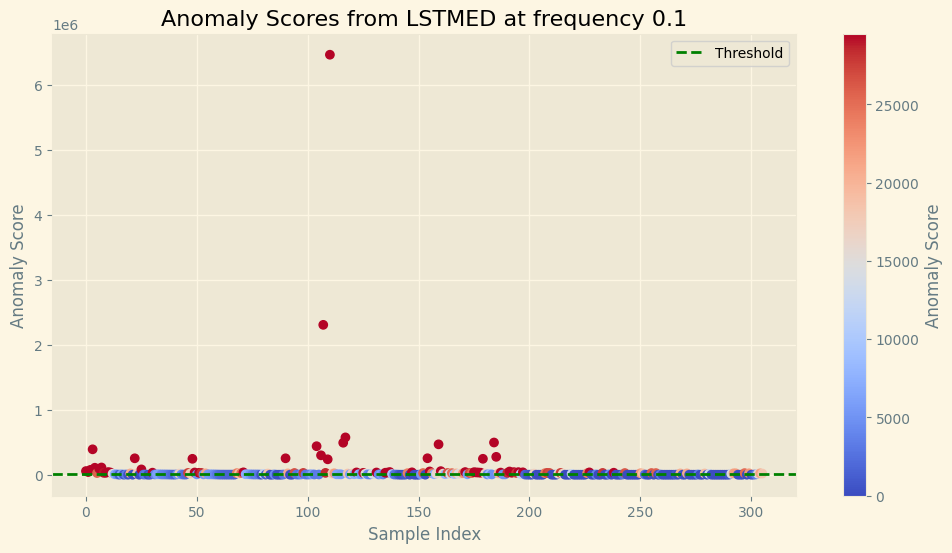

Number of anomalies detected: 115


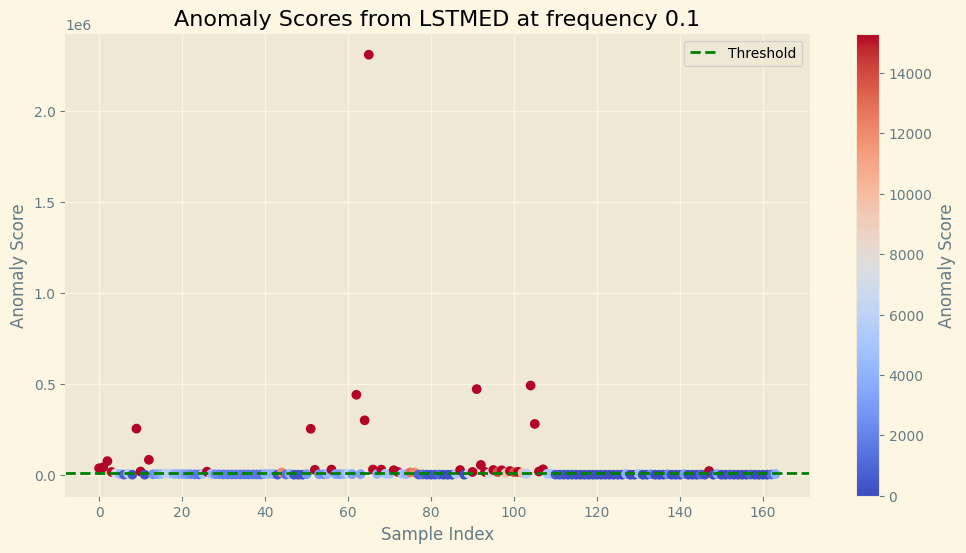

Number of anomalies detected: 39


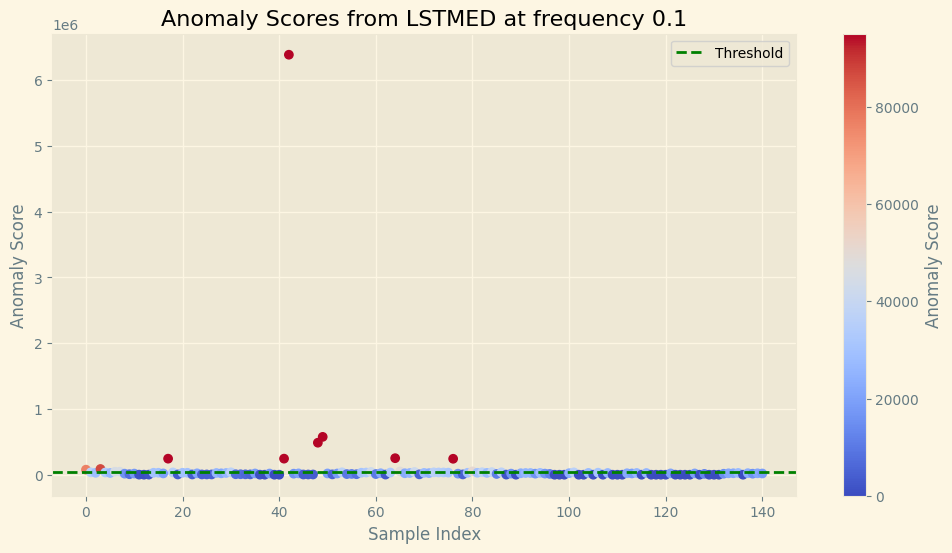

Number of anomalies detected: 11


In [12]:
anomalies_detected = plot_anomalies(anomaly_scores, freq, thresholds[1])
anomalies_detected1 = plot_anomalies(anomaly_scores1, freq, thresholds_1[1])
anomalies_detected5 = plot_anomalies(anomaly_scores5, freq, thresholds_5[1])

In [13]:
np.count_nonzero(y_collision), np.count_nonzero(y_collision_1), np.count_nonzero(y_collision_5)

(105, 35, 56)

In [14]:
compute_metrics(anomaly_scores, y_collision, thresholds[1])
print("############################################")
compute_metrics(anomaly_scores1, y_collision_1, thresholds_1[1])
print("############################################")
compute_metrics(anomaly_scores5, y_collision_5, thresholds_5[1])

ROC AUC Score: 0.8321
Detected anomaly class: 1
Threshold: 14757.7562
F1 Score: 0.7364
Accuracy: 0.8105
Precision: 0.7043
Recall: 0.7714
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       201
           1       0.70      0.77      0.74       105

    accuracy                           0.81       306
   macro avg       0.79      0.80      0.79       306
weighted avg       0.82      0.81      0.81       306

############################################
ROC AUC Score: 0.7776
Detected anomaly class: 1
Threshold: 7648.4346
F1 Score: 0.4054
Accuracy: 0.7317
Precision: 0.3846
Recall: 0.4286
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       129
           1       0.38      0.43      0.41        35

    accuracy                           0.73       164
   macro avg       0.61      0.62      0.62       164
weighted avg       0.74      0.73      0.74       164

############################

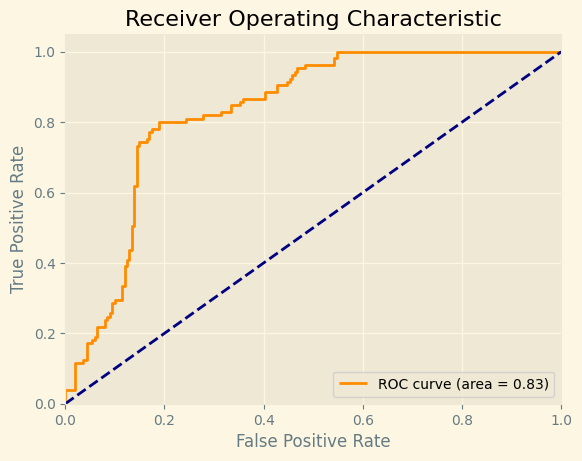

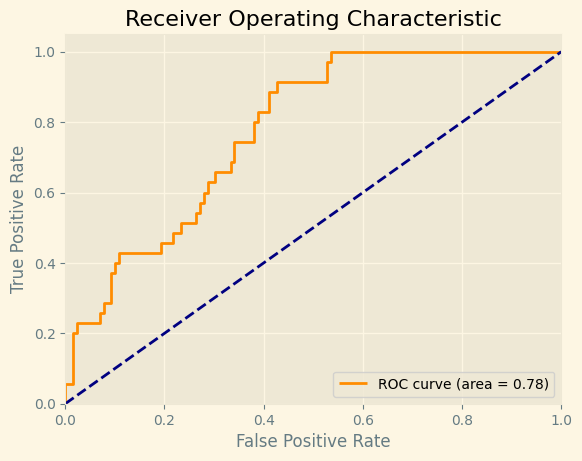

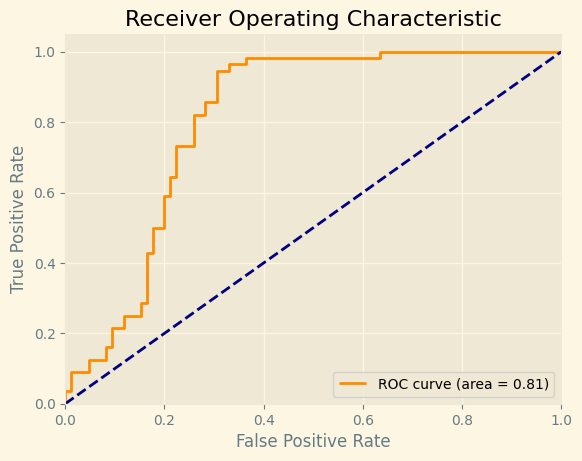

In [15]:
plot_roc_curve(y_collision, anomaly_scores)
plot_roc_curve(y_collision_1, anomaly_scores1)
plot_roc_curve(y_collision_5, anomaly_scores5)

## Map anomalies to original time series

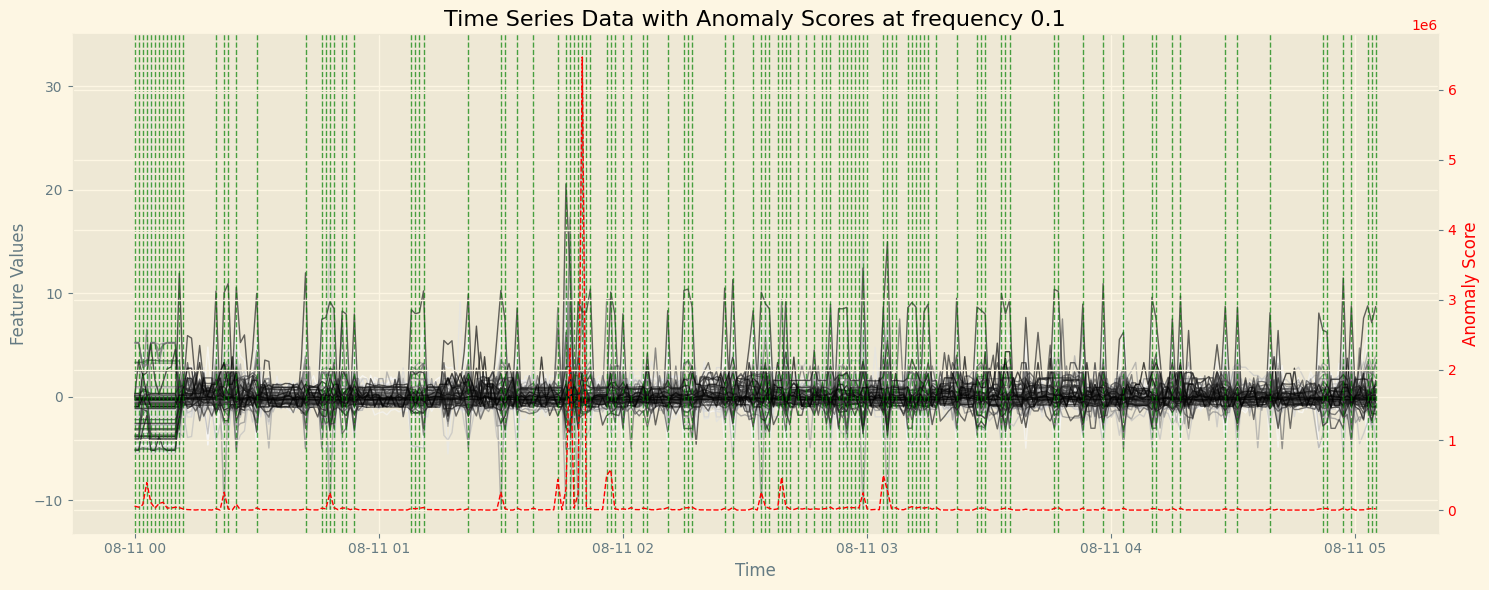

Top 115 Anomalies:
              timestamp  anomaly_score  \
110 2022-08-11 01:50:00   6.467558e+06   
107 2022-08-11 01:47:00   2.308014e+06   
117 2022-08-11 01:57:00   5.747370e+05   
184 2022-08-11 03:04:00   4.961377e+05   
116 2022-08-11 01:56:00   4.924773e+05   
..                  ...            ...   
158 2022-08-11 02:38:00   1.616600e+04   
213 2022-08-11 03:33:00   1.574067e+04   
12  2022-08-11 00:12:00   1.508185e+04   
126 2022-08-11 02:06:00   1.502514e+04   
303 2022-08-11 05:03:00   1.499016e+04   

     machine_nameKuka Robot_apparent_power-_Average power  \
110                                          -0.911260      
107                                          -1.181816      
117                                          -1.299415      
184                                          -1.514041      
116                                           0.033111      
..                                                 ...      
158                                           0.2

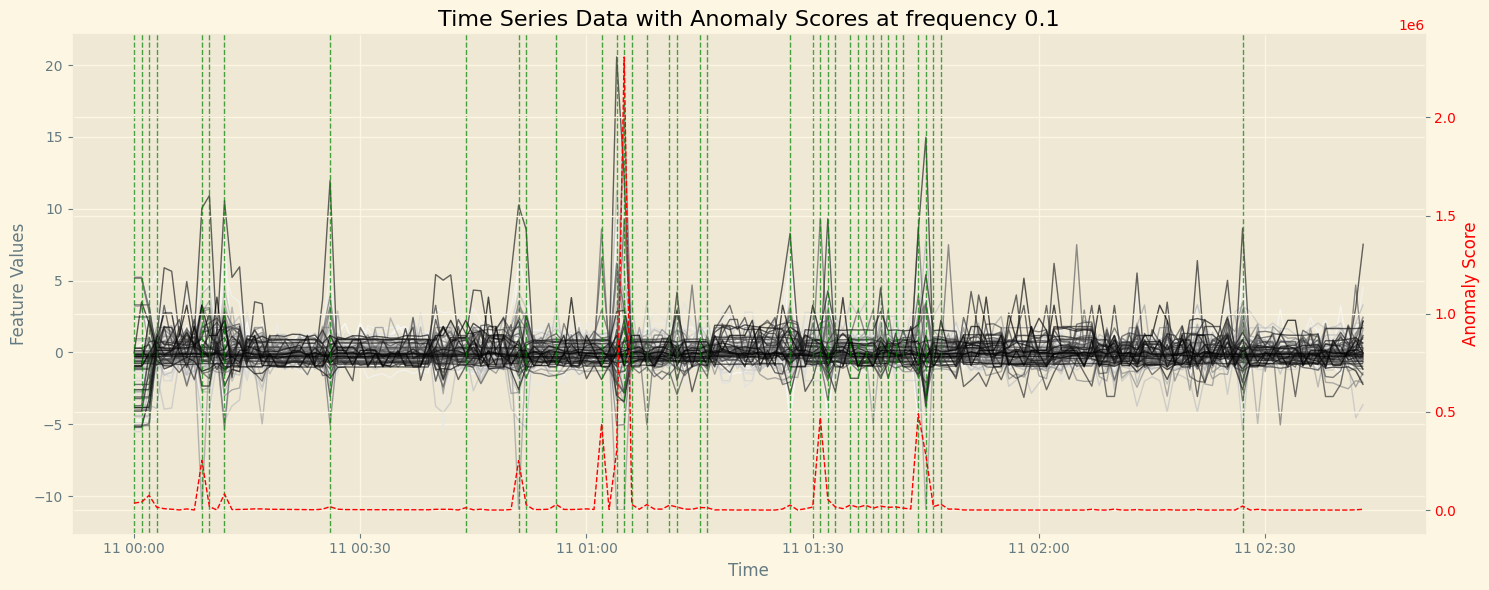

Top 39 Anomalies:
              timestamp  anomaly_score  \
65  2022-08-11 01:05:00   2.307787e+06   
104 2022-08-11 01:44:00   4.901178e+05   
91  2022-08-11 01:31:00   4.704693e+05   
62  2022-08-11 01:02:00   4.392872e+05   
64  2022-08-11 01:04:00   2.989601e+05   
105 2022-08-11 01:45:00   2.790904e+05   
9   2022-08-11 00:09:00   2.533097e+05   
51  2022-08-11 00:51:00   2.523084e+05   
12  2022-08-11 00:12:00   8.199445e+04   
2   2022-08-11 00:02:00   7.471548e+04   
92  2022-08-11 01:32:00   5.372082e+04   
1   2022-08-11 00:01:00   4.090885e+04   
0   2022-08-11 00:00:00   3.546179e+04   
107 2022-08-11 01:47:00   2.969252e+04   
66  2022-08-11 01:06:00   2.860039e+04   
56  2022-08-11 00:56:00   2.821202e+04   
68  2022-08-11 01:08:00   2.796804e+04   
52  2022-08-11 00:52:00   2.688413e+04   
95  2022-08-11 01:35:00   2.592376e+04   
87  2022-08-11 01:27:00   2.561332e+04   
71  2022-08-11 01:11:00   2.477588e+04   
97  2022-08-11 01:37:00   2.460173e+04   
147 2022-08-11 0

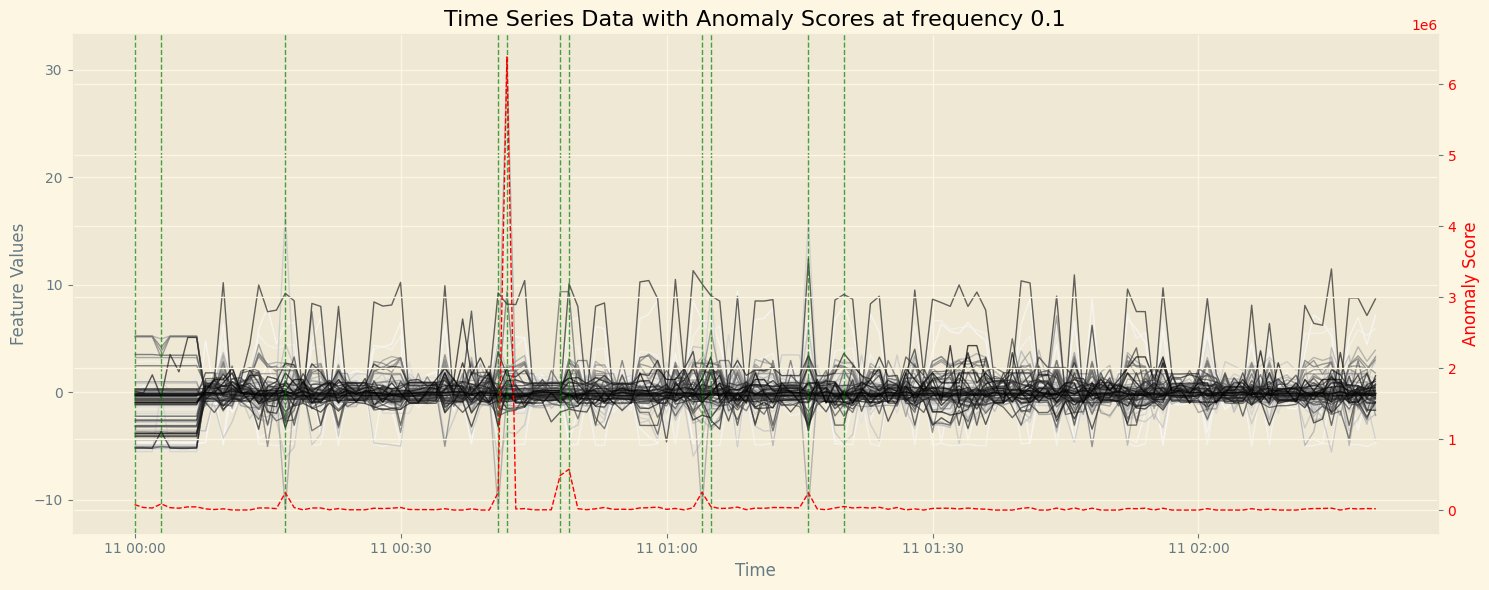

Top 11 Anomalies:
             timestamp  anomaly_score  \
42 2022-08-11 00:42:00   6.387437e+06   
49 2022-08-11 00:49:00   5.757377e+05   
48 2022-08-11 00:48:00   4.869679e+05   
64 2022-08-11 01:04:00   2.515139e+05   
41 2022-08-11 00:41:00   2.445528e+05   
17 2022-08-11 00:17:00   2.441829e+05   
76 2022-08-11 01:16:00   2.426501e+05   
3  2022-08-11 00:03:00   8.707548e+04   
0  2022-08-11 00:00:00   7.678802e+04   
80 2022-08-11 01:20:00   5.053927e+04   
65 2022-08-11 01:05:00   4.872966e+04   

    machine_nameKuka Robot_apparent_power-_Average power  \
42                                          -0.911260      
49                                          -1.299415      
48                                           0.033111      
64                                          -0.859449      
41                                          -0.850698      
17                                          -0.707436      
76                                          -1.338344      
3        

In [16]:
plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq)
plot_anomalies_over_time(X_test1, anomaly_scores1, anomalies_detected1, freq)
plot_anomalies_over_time(X_test5, anomaly_scores5, anomalies_detected5, freq)